# Atmospheric composition distribution by CAMS and GOME-2

### Main goal:
* Compare GOME-2 and CAMS datasets for NO<sub>2</sub> (Level 3).

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3
import wget # Important for GOME-2
import subprocess # Important for GOME-2
import bs4 # Important for GOME-2 L2
import h5py # Important for GOME-2 L2

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_gome.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

## 1. Define datasets

In [4]:
# Define component
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Define sensor
sensor = 'gome'
sensor_type = 'L3'
satellites = ['A', 'B', 'C']
apply_kernels = False

# Define search period
start_date = '2016-01-01'
end_date = '2016-12-31'

# Define extent
lon_min = -25
lon_max = 45
lat_min = 30
lat_max = 70

# Define resolution (Minimum: 0.25x.0.25)
lat_res = 1
lon_res = 1

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In months: ('2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12')
SEARCH BOUNDING BOX
Latitudes: from 30 to 70
Longitudes: from -25 to 45


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')

The file exists, it will not be downloaded again.


In [8]:
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 54, longitude: 94, time: 12)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2016-01-01 2016-02-01 ... 2016-12-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 30.0 30.75 31.5 32.25 ... 68.25 69.0 69.75
  * longitude   (longitude) float64 -24.75 -24.0 -23.25 ... 43.5 44.25 45.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-11-30T22:48 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, component, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels)

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [11]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, satellites)

RESULTS
For 2016-01:
GOME_NO2_Global_201601_METOPA_DLR_v1.nc was downloaded.
GOME_NO2_Global_201601_METOPB_DLR_v1.nc was downloaded.
GOME_NO2_Global_201601_METOPC_DLR_v1.nc is not available.
For 2016-02:
GOME_NO2_Global_201602_METOPA_DLR_v1.nc was downloaded.
GOME_NO2_Global_201602_METOPB_DLR_v1.nc was downloaded.
GOME_NO2_Global_201602_METOPC_DLR_v1.nc is not available.
For 2016-03:
GOME_NO2_Global_201603_METOPA_DLR_v1.nc was downloaded.
GOME_NO2_Global_201603_METOPB_DLR_v1.nc was downloaded.
GOME_NO2_Global_201603_METOPC_DLR_v1.nc is not available.
For 2016-04:
GOME_NO2_Global_201604_METOPA_DLR_v1.nc was downloaded.
GOME_NO2_Global_201604_METOPB_DLR_v1.nc was downloaded.
GOME_NO2_Global_201604_METOPC_DLR_v1.nc is not available.
For 2016-05:
GOME_NO2_Global_201605_METOPA_DLR_v1.nc was downloaded.
GOME_NO2_Global_201605_METOPB_DLR_v1.nc was downloaded.
GOME_NO2_Global_201605_METOPC_DLR_v1.nc is not available.
For 2016-06:
GOME_NO2_Global_201606_METOPA_DLR_v1.nc was downloaded.
GOME_NO2

In [12]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, 
                              dates, satellites, lat_res, lon_res)
sensor_ds

<xarray.Dataset>
Dimensions:        (latitude: 180, longitude: 360, time: 12)
Coordinates:
  * longitude      (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude       (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time           (time) datetime64[ns] 2016-01-01 2016-02-01 ... 2016-12-01
Data variables:
    sensor_column  (time, longitude, latitude) float32 nan nan nan ... nan nan
Attributes:
    units:    molec cm-2

## 4. Match data

In [13]:
match_table = generate_match_table(sensor_ds, model_ds, bbox, sensor, component_nom, apply_kernels)
match_table

FOR MONTH: 2016-01
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2016-02
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2016-03
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2016-04
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2016-05
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2016-06
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2016-07
The model dataset does not contain levels data.
The model dataset will be merged with the sensor da

,latitude,longitude,sensor_column,time,model_column
0,29.5,-25.5,6.139152e+14,2016-01-01,9.829262e+14
1,29.5,-24.5,5.397966e+14,2016-01-01,9.829262e+14
2,29.5,-23.5,5.605558e+14,2016-01-01,9.906122e+14
3,29.5,-22.5,5.581580e+14,2016-01-01,1.000003e+15
4,29.5,-21.5,5.738225e+14,2016-01-01,1.005260e+15
...,...,...,...,...,...
2906,69.5,40.5,NaN,2016-12-01,1.093348e+15
2907,69.5,41.5,NaN,2016-12-01,1.093300e+15
2908,69.5,42.5,NaN,2016-12-01,1.102586e+15
2909,69.5,43.5,NaN,2016-12-01,1.096853e+15


## 5. Merge data and calculate difference

In [14]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, sensor, apply_kernels)
merge_table

sensor_column  model_column    difference
latitude longitude time                                                 
29.5     -25.5     2016-01-01   6.139152e+14  9.829262e+14 -3.690110e+14
                   2016-02-01   5.829329e+14  1.049008e+15 -4.660751e+14
                   2016-03-01   4.889781e+14  1.314163e+15 -8.251847e+14
                   2016-04-01   3.479244e+14  1.318950e+15 -9.710251e+14
                   2016-05-01   4.540081e+14  1.441230e+15 -9.872223e+14
...                                      ...           ...           ...
69.5      44.5     2016-08-01   6.657063e+14  1.340978e+15 -6.752721e+14
                   2016-09-01   9.037837e+14  1.408603e+15 -5.048195e+14
                   2016-10-01   6.969202e+14  1.411892e+15 -7.149717e+14
                   2016-11-01            NaN  1.689097e+15           NaN
                   2016-12-01            NaN  1.087586e+15           NaN

[34932 rows x 3 columns]

In [15]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,sensor_column,model_column,difference
count,3.272300e+04,3.493200e+04,3.272300e+04
mean,1.635420e+15,2.975048e+15,-1.368823e+15
std,1.400441e+15,1.920200e+15,1.246131e+15
min,5.961441e+12,3.212460e+14,-1.498267e+16
25%,7.888727e+14,1.630025e+15,-1.790146e+15
50%,1.202237e+15,2.453828e+15,-1.172340e+15
75%,1.997838e+15,3.699219e+15,-6.823559e+14
max,2.922004e+16,2.110932e+16,2.196662e+16


## 6. Show comparison plots

### Select plot dates

In [16]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2016-01' '2016-02' '2016-03' '2016-04' '2016-05' '2016-06' '2016-07'
 '2016-08' '2016-09' '2016-10' '2016-11' '2016-12']


### Select plot extent

In [17]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-25, 30), (45, 70))


### Compare CAMS and GOME-2 total columns

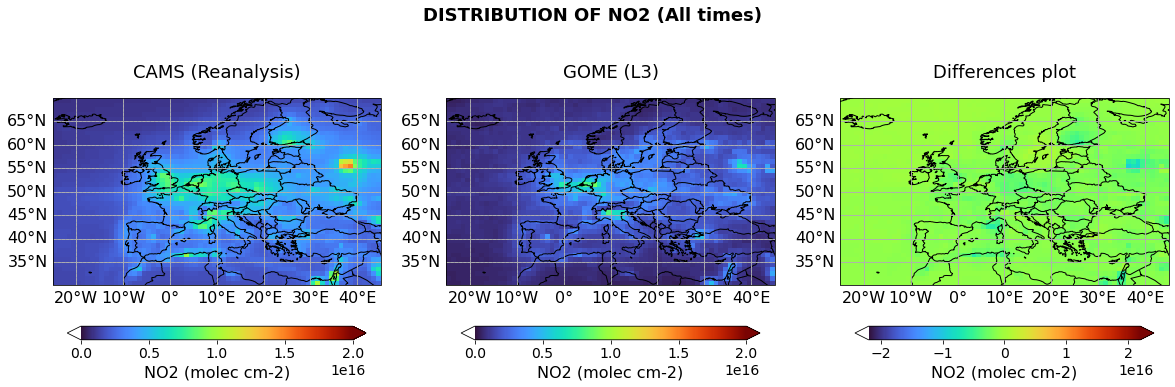

In [18]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'aggregated'

# Choose range (original, equal or manual)
range_type = 'manual'
vmin_manual = 0
vmax_manual = 2*10**16

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'turbo'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

sensor_column  \
lat_search lon_search latitude longitude time                        
50         60         49.5     44.5      2016-01-01   2.616441e+15   
                                         2016-02-01   1.493692e+15   
                                         2016-03-01   1.690310e+15   
                                         2016-04-01   1.702807e+15   
                                         2016-05-01   1.504509e+15   
                                         2016-06-01   1.263639e+15   
                                         2016-07-01   1.370919e+15   
                                         2016-08-01   1.426375e+15   
                                         2016-09-01   1.798856e+15   
                                         2016-10-01   1.342507e+15   
                                         2016-11-01   2.858777e+15   
                                         2016-12-01   2.562044e+15   
4          10         29.5     9.5       2016-01-01   4.208121e+14   
                                         2016-02-01   4.358655e+14   
                                         2016-03-01   4.868144e+14   
                                         2016-04-01   3.643057e+14   
                                         2016-05-01   4.019416e+14   
                                         2016-06-01   4.266247e+14   
                                         2016-07-01   3.403197e+14   
                                         2016-08-01   3.562270e+14   
                                         2016-09-01   3.098515e+14   
                                         2016-10-01   3.978151e+14   
                                         2016-11-01   3.353362e+14   
                                         2016-12-01   3.453104e+14   
20         30         29.5     29.5      2016-01-01   7.111338e+14   
                                         2016-02-01   7.355179e+14   
                                         2016-03-01   8.193087e+14   
                                         2016-04-01   9.838072e+14   
                                         2016-05-01   8.240065e+14   
                                         2016-06-01   7.620130e+14   
                                         2016-07-01   4.822472e+14   
                                         2016-08-01   5.437079e+14   
                                         2016-09-01   5.906741e+14   
                                         2016-10-01   7.308608e+14   
                                         2016-11-01   1.198337e+15   
                                         2016-12-01   6.564444e+14   

                                                     model_column  \
lat_search lon_search latitude longitude time                       
50         60         49.5     44.5      2016-01-01  5.744426e+15   
                                         2016-02-01  3.790552e+15   
                                         2016-03-01  3.494501e+15   
                                         2016-04-01  3.222942e+15   
                                         2016-05-01  2.433225e+15   
                                         2016-06-01  2.350477e+15   
                                         2016-07-01  2.648629e+15   
                                         2016-08-01  3.094571e+15   
                                         2016-09-01  3.508391e+15   
                                         2016-10-01  3.490555e+15   
                                         2016-11-01  3.914823e+15   
                                         2016-12-01  5.850552e+15   
4          10         29.5     9.5       2016-01-01  1.160847e+15   
                                         2016-02-01  1.269806e+15   
                                         2016-03-01  1.448182e+15   
                                         2016-04-01  1.524742e+15   
                                         2016-05-01  1.667357e+15   
                                         2016-06-01  1.611770e+15   
            

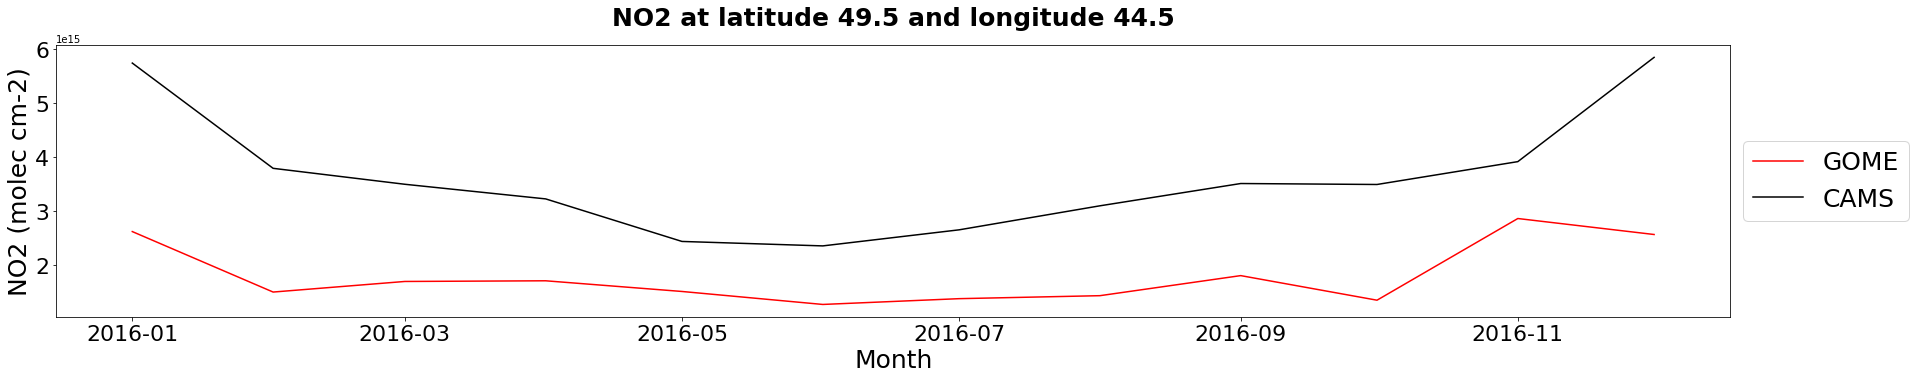

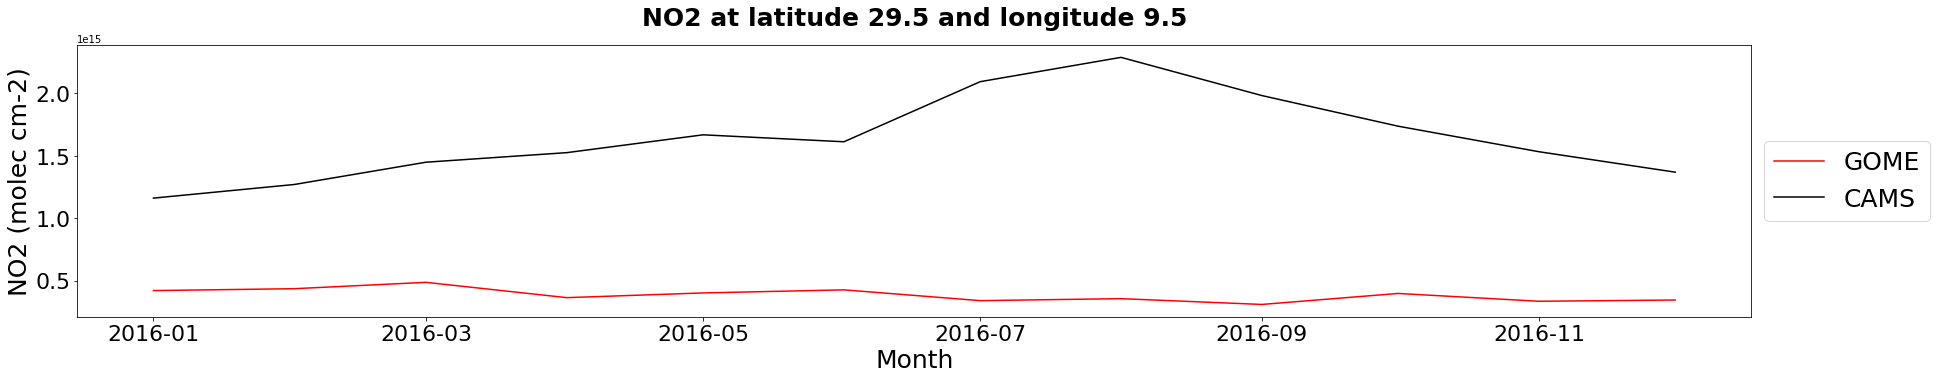

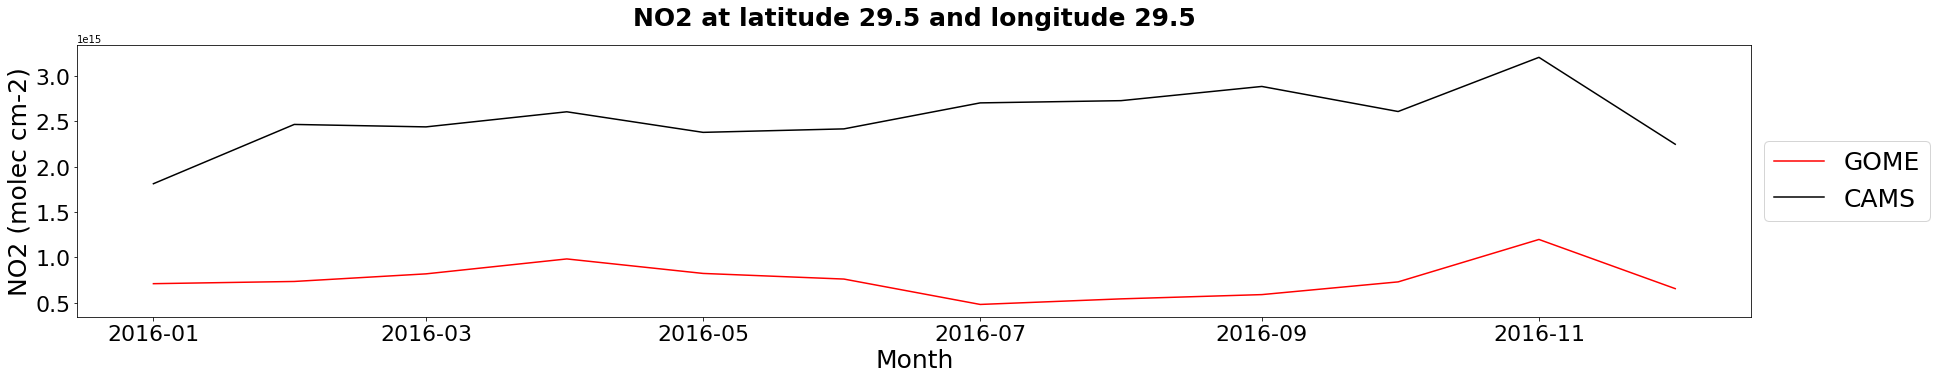

In [19]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units)
retrieval_table_all

## 8. Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 1.02 + (1.33E+15)
Coefficient of determination (R2): 0.57


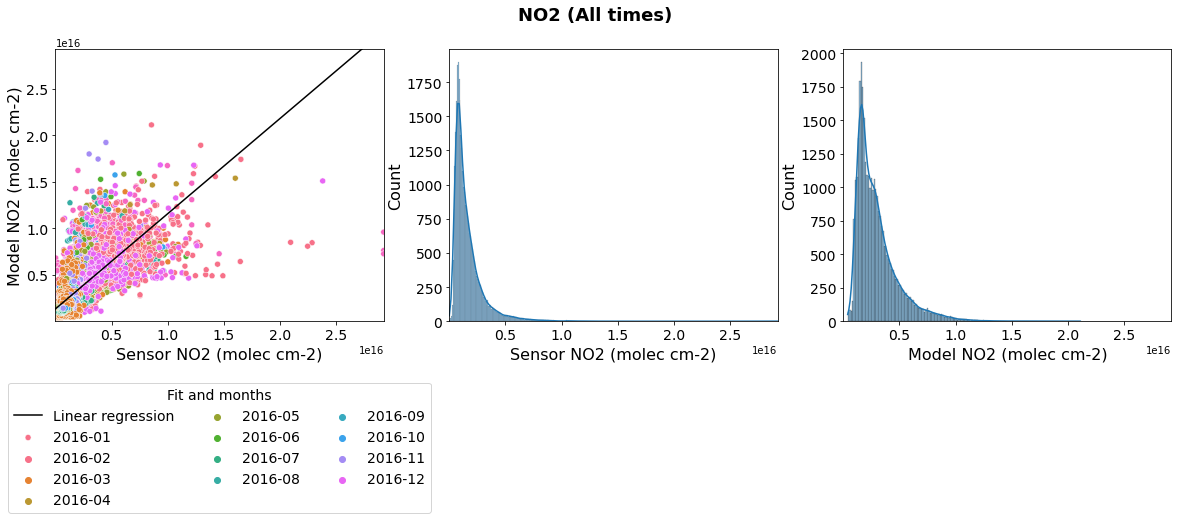

In [20]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [21]:
summary

,Period,Location,Score,Coefficient,Intercept
0,"[2016-01-01T00:00:00.000000000, 2016-02-01T00:...","((-25, 30), (45, 70))",0.569869,1.023836,1.329841e+15


## 9. Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 1.00 + (1.29E+15)
Coefficient of determination (R2): 0.64


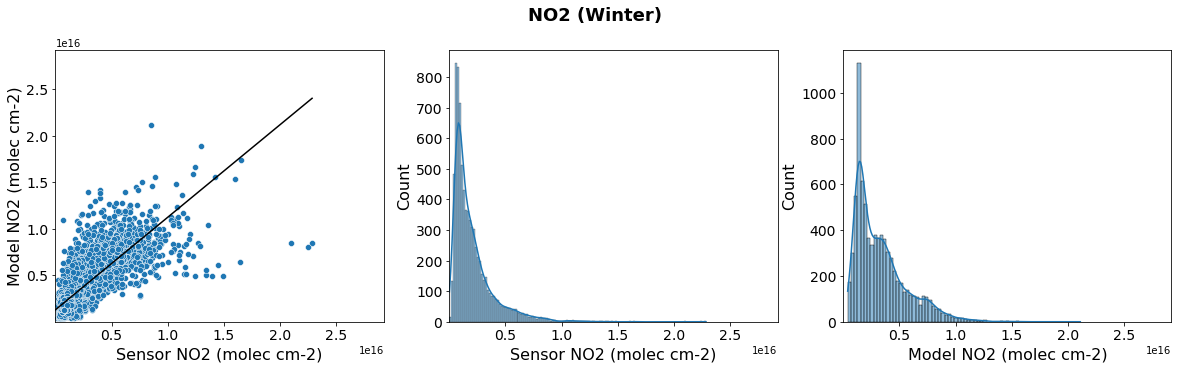

Fit equation: NO2_model = NO2_sensor * 1.00 + (1.00E+15)
Coefficient of determination (R2): 0.61


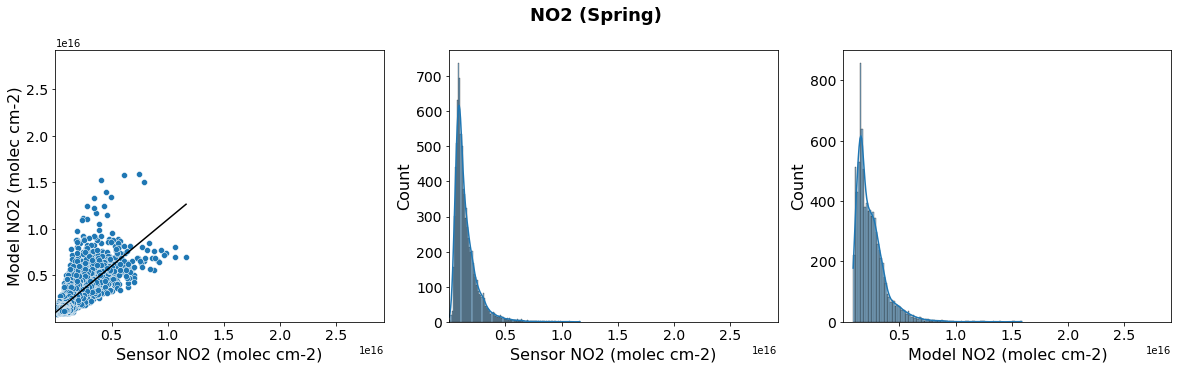

Fit equation: NO2_model = NO2_sensor * 1.07 + (1.27E+15)
Coefficient of determination (R2): 0.52


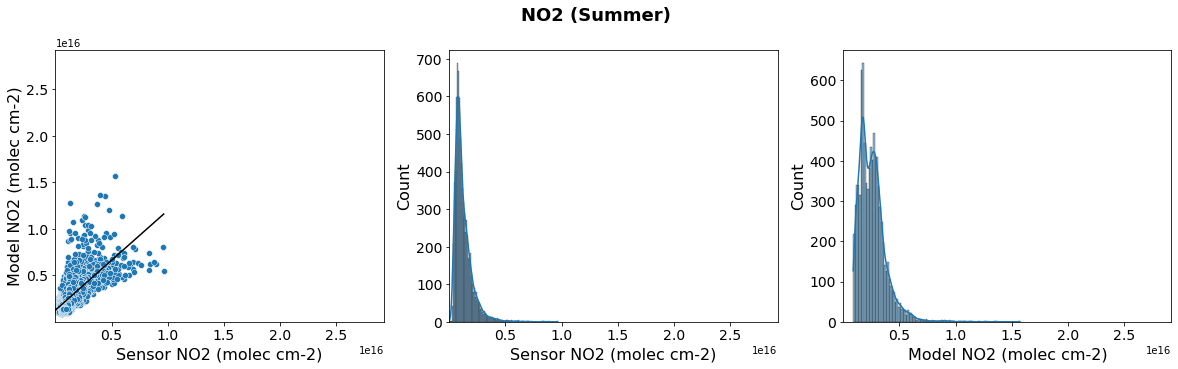

Fit equation: NO2_model = NO2_sensor * 1.01 + (1.90E+15)
Coefficient of determination (R2): 0.48


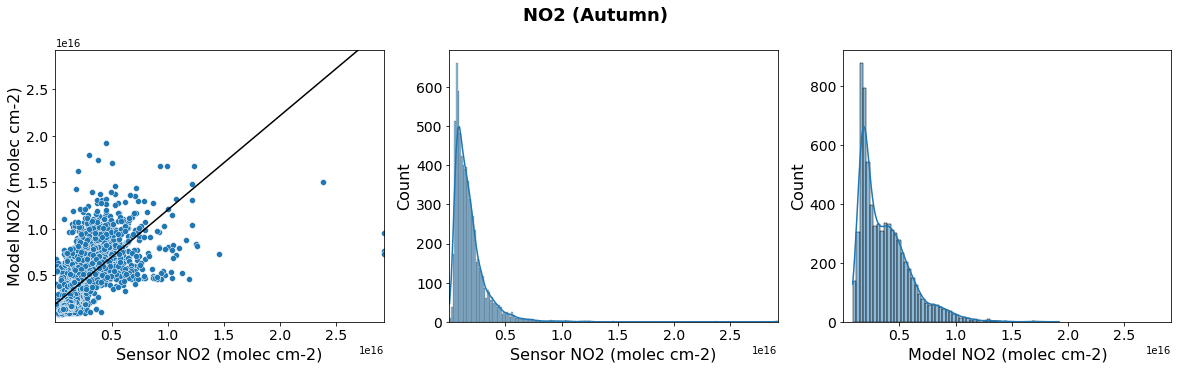

In [22]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [23]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Winter,"((-25, 30), (45, 70))",0.641458,0.995089,1.293061e+15
1,Spring,"((-25, 30), (45, 70))",0.611850,1.000726,1.002745e+15
2,Summer,"((-25, 30), (45, 70))",0.516838,1.070899,1.266051e+15
3,Autumn,"((-25, 30), (45, 70))",0.476373,1.013369,1.900014e+15


## 10. Scatter plots by country (Google API required!)

In [24]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['China', 'India', 'Vietnam']

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['China', 'India', 'Vietnam']\n\nlim_min = None\nlim_max = None\n\nsummary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, \n                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [25]:
#summary